In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from numpy.random import default_rng
from typing import Tuple, Any, Union

In [20]:
rng = default_rng(1234)

In [21]:
class BaseModel:
    def __init__(self, n: int, d: int, *args, **kwargs) -> None:
        self.n = n
        self.d = d

    def __getitem__(self, idx: Union[int, np.ndarray], *args, **kwargs) -> Any:
        """Get the i-th item of the model."""
        assert False, "Not implemented."

    def gradient(
        self, x: np.ndarray, idx: Union[int, np.ndarray], *args, **kwargs
    ) -> np.ndarray:
        """Computes the gradient at x for the i-th sample."""
        assert False, "Not implemented."

    def alpha(
        self, x: np.ndarray, idx: Union[int, np.ndarray], *args, **kwargs
    ) -> np.ndarray:
        """Computes $\alpha$ for hessian update in stochastic newton method."""
        assert False, "Not implemented."

    def __repr__(self) -> str:
        return f"Model(n={self.n}, d={self.d})"

In [22]:
class BaseScheduler:
    """Step size scheduler."""

    def __init__(self) -> None:
        self.reset()

    def reset(self) -> None:
        self.t = 0

    def step(self) -> float:
        pass


class AlphaScheduler(BaseScheduler):
    def __init__(self, alpha: float, c_alpha: float) -> None:
        super().__init__()
        assert 0.5 < alpha < 1, "alpha must be in ]1/2, 1[."
        assert c_alpha > 0, "c_alpha must be positive."
        self.alpha = alpha
        self.c_alpha = c_alpha

    def step(self, *args: Any, **kwds: Any) -> float:
        self.t = self.t + 1
        return self.c_alpha / self.t**self.alpha

# Linear regression

In [23]:
class LinearRegressionModel(BaseModel):
    def __init__(self, n: int, d: int, theta_star: np.ndarray, *args, **kwargs) -> None:
        super().__init__(n=n, d=d, *args, **kwargs)
        self.n = n
        self.d = d
        self.theta_star = theta_star

        self.Xs = rng.multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=(n,))
        eps = rng.normal(loc=0, scale=1, size=(n, 1))
        self.ys = self.Xs @ self.theta_star.T + eps

    def __getitem__(self, idx: Union[int, np.ndarray]) -> Any:
        X = self.Xs[idx]
        y = self.ys[idx]
        return X, y

    def gradient(self, theta: np.ndarray, idx: Union[int, np.ndarray]) -> np.ndarray:
        X, y = self[idx]
        a = np.einsum("Nd, Nd -> N", X, theta).reshape(-1, 1)
        assert a.shape == y.shape and a.ndim == X.ndim
        return X * (a - y)

    def alpha(
        self, theta: np.ndarray, idx: Union[int, np.ndarray], *args, **kwargs
    ) -> np.ndarray:
        """Computes $\alpha$ for hessian update in stochastic newton method."""
        alphas = np.ones_like(idx)
        return alphas

    def __repr__(self) -> str:
        return f"LinReg(n={self.n}, d={self.d})"

In [24]:
n = 10_000
d = 5
b = 50
r = 1

theta_star = rng.normal(size=(1, d))
theta_0 = rng.normal(size=(b, d))
theta_0 = theta_star + r * theta_0 / np.linalg.norm(theta_0, axis=-1, keepdims=True)

model = LinearRegressionModel(n=n, d=d, theta_star=theta_star)
scheduler = AlphaScheduler(alpha=2 / 3, c_alpha=1)

## Stochastic Gradient algorithm

In [25]:
def run_online_sgd(
    model: BaseModel,
    scheduler: BaseScheduler,
    theta_0: np.ndarray,
    averaged: bool = False,
) -> np.ndarray:
    N, d = theta_0.shape
    thetas = np.empty((model.n + 1, N, d))
    thetas[0] = theta_0.copy()
    theta = theta_0

    scheduler.reset()
    perm = np.stack([rng.permutation(model.n) for _ in range(N)], axis=-1)
    for t in tqdm(range(model.n)):
        gamma = scheduler.step()
        g = model.gradient(theta, perm[t])
        theta = theta - gamma * g
        if averaged:
            avg = thetas[t] + (theta - thetas[t]) / (t + 2)
            thetas[t + 1] = avg.copy()
        else:
            thetas[t + 1] = theta.copy()

    return thetas

  0%|          | 0/10000 [00:00<?, ?it/s]

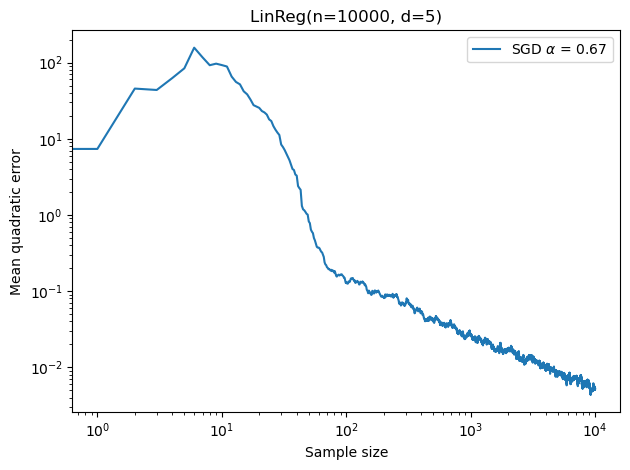

In [26]:
thetas_sgd = run_online_sgd(model, scheduler, theta_0)
errors_sgd = np.square(thetas_sgd - theta_star.reshape(1, 1, -1)).sum(-1).mean(-1)

fig, ax = plt.subplots(layout="tight")

ax.loglog(errors_sgd, label=rf"SGD $\alpha$ = {scheduler.alpha:.2f}")

ax.set_xlabel("Sample size")
ax.set_ylabel("Mean quadratic error")
ax.set_title(f"{model}")
ax.legend()

plt.show()

## Stochastic Newton algorithm


In [27]:
def run_online_sn(
    model: BaseModel, theta_0: np.ndarray, lmbd: float = 1.0
) -> np.ndarray:
    N, d = theta_0.shape

    def _update_inv_hess(
        inv_hesses: np.ndarray, x: np.ndarray, alphas: float
    ) -> np.ndarray:
        u = np.einsum("Nij, Nj -> Ni", inv_hesses, x)
        a = np.einsum("Ni, Ni -> N", x, u).reshape(-1, 1, 1)
        assert alphas.shape == a.shape

        m = alphas / (1 + alphas * a)
        outer = np.einsum("Ni, Nj -> Nij", u, u)
        return inv_hesses - m * outer

    inv_hesses = np.stack([np.eye(d) / lmbd for _ in range(N)])
    thetas = np.empty((model.n + 1, N, d))
    thetas[0] = theta_0.copy()
    theta = theta_0

    perm = np.stack([rng.permutation(model.n) for _ in range(N)], axis=-1)
    for t in tqdm(range(model.n)):
        g = model.gradient(theta, perm[t])
        gp = np.einsum("Nij, Nj -> Ni", inv_hesses, g)
        theta = theta - gp * (t + 1) / (t + 50)
        thetas[t + 1] = theta.copy()
        # Update hessian estimators
        alphas = model.alpha(theta, perm[t]).reshape(-1, 1, 1)
        inv_hesses = _update_inv_hess(inv_hesses, model[perm[t]][0], alphas)

    return thetas

## Streaming Newton


In [30]:
def run_streaming_sn(
    model: BaseModel,
    theta_0: np.ndarray,
    p: float = None,
    b: int = None,
    lmbd: float = 1.0,
) -> np.ndarray:
    def _update_inv_hess(
        inv_hesses: np.ndarray,
        xs: np.ndarray,
        alphass: np.ndarray,
    ) -> np.ndarray:
        for x, alphas in zip(xs, alphass):
            u = np.einsum("Nij, Nj -> Ni", inv_hesses, x)
            a = np.einsum("Ni, Ni -> N", x, u).reshape(-1, 1, 1)
            assert alphas.shape == a.shape

            m = alphas / (1 + alphas * a)
            outer = np.einsum("Ni, Nj -> Nij", u, u)
            inv_hesses = inv_hesses - m * outer
        return inv_hesses

    N, d = theta_0.shape
    p = 1 / d if p is None else p
    assert 0 < p <= 1, "p must be in (0, 1]."
    b = d if b is None else b
    assert model.n % b == 0, "b must divide the sample size."

    inv_hesses = np.stack([np.eye(d) / lmbd for _ in range(N)])
    thetas = np.empty((model.n // b + 1, N, d))
    thetas[0] = theta_0.copy()
    theta = theta_0

    perm = np.stack([rng.permutation(model.n) for _ in range(N)], axis=-1).reshape(
        model.n // b, b, N
    )
    sum_z_mask = np.ones((N, 1))
    for t in tqdm(range(perm.shape[0])):
        g = np.zeros((N, d))
        # TODO: vectorize
        for inds in perm[t]:
            g = g + model.gradient(theta, inds)
        g = g / b
        gp = np.einsum("Nij, Nj -> Ni", inv_hesses, g)
        theta = theta - gp * sum_z_mask / (t + 50)
        thetas[t + 1] = theta.copy()
        # Update hessian estimators
        alphas = np.stack(
            [model.alpha(theta, inds).reshape(-1, 1, 1) for inds in perm[t]]
        )
        alphas = alphas * lmbd
        z_mask = np.random.rand(b) < p

        inv_hesses = _update_inv_hess(
            inv_hesses, model[perm[t]][0][z_mask], alphas[z_mask]
        )
        sum_z_mask = sum_z_mask + z_mask.reshape(1, -1).repeat(N, axis=0).sum(
            -1, keepdims=True
        )

    return thetas

In [31]:
def run_averaged_streaming_sn(
    model: BaseModel,
    scheduler: BaseScheduler,
    theta_0: np.ndarray,
    p: float = None,
    b: int = None,
    lmbd: float = 1.0,
) -> np.ndarray:
    def _update_inv_hess(
        inv_hesses: np.ndarray,
        xs: np.ndarray,
        alphass: np.ndarray,
    ) -> np.ndarray:
        for x, alphas in zip(xs, alphass):
            u = np.einsum("Nij, Nj -> Ni", inv_hesses, x)
            a = np.einsum("Ni, Ni -> N", x, u).reshape(-1, 1, 1)
            assert alphas.shape == a.shape

            m = alphas / (1 + alphas * a)
            outer = np.einsum("Ni, Nj -> Nij", u, u)
            inv_hesses = inv_hesses - m * outer
        return inv_hesses

    N, d = theta_0.shape
    p = 1 / d if p is None else p
    assert 0 < p <= 1, "p must be in (0, 1]."
    b = d if b is None else b
    assert model.n % b == 0, "b must divide the sample size."

    inv_hesses = np.stack([np.eye(d) / lmbd for _ in range(N)])
    thetas = np.empty((model.n // b + 1, N, d))
    thetas[0] = theta_0.copy()
    theta = theta_0

    perm = np.stack([rng.permutation(model.n) for _ in range(N)], axis=-1).reshape(
        model.n // b, b, N
    )
    sum_z_mask = np.ones((N, 1))
    scheduler.reset()
    for _ in range(20):
        scheduler.step()
    log_sum = 0
    for t in tqdm(range(perm.shape[0])):
        g = np.zeros((N, d))
        # TODO: vectorize
        for inds in perm[t]:
            g = g + model.gradient(theta, inds)
        g = g / b
        gp = np.einsum("Nij, Nj -> Ni", inv_hesses, g) * sum_z_mask
        gamma = scheduler.step()
        theta = theta - gamma * gp
        log = np.log(t + 1) ** 2 if t > 0 else 1
        log_sum = log_sum + log
        thetas[t + 1] = thetas[t] + log / log_sum * (theta - thetas[t])
        # Update hessian estimators
        alphas = np.stack(
            [model.alpha(theta, inds).reshape(-1, 1, 1) for inds in perm[t]]
        )
        alphas = alphas * lmbd
        z_mask = np.random.rand(b) < p

        inv_hesses = _update_inv_hess(
            inv_hesses, model[perm[t]][0][z_mask], alphas[z_mask]
        )
        sum_z_mask = sum_z_mask + z_mask.reshape(1, -1).repeat(N, axis=0).sum(
            -1, keepdims=True
        )
    return thetas

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

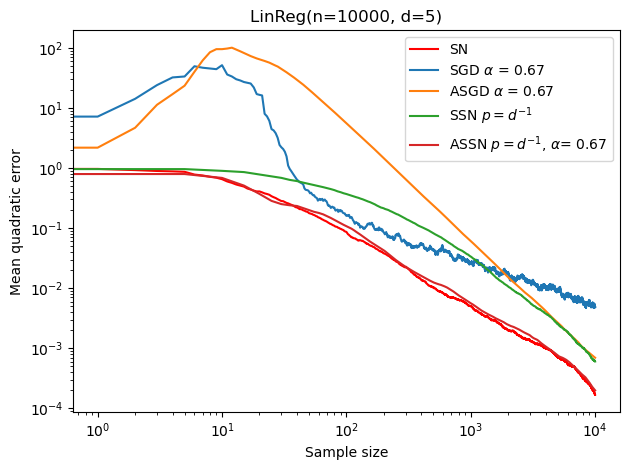

In [32]:
thetas_sn = run_online_sn(model, theta_0)
thetas_sgd = run_online_sgd(model, scheduler, theta_0)
thetas_asgd = run_online_sgd(model, scheduler, theta_0, averaged=True)
thetas_ssn = run_streaming_sn(model, theta_0)
thetas_assn = run_averaged_streaming_sn(model, scheduler, theta_0)

errors_sgd = np.square(thetas_sgd - theta_star.reshape(1, 1, -1)).sum(-1).mean(-1)
errors_asgd = np.square(thetas_asgd - theta_star.reshape(1, 1, -1)).sum(-1).mean(-1)
errors_sn = np.square(thetas_sn - theta_star.reshape(1, 1, -1)).sum(-1).mean(-1)
errors_ssn = np.square(thetas_ssn - theta_star.reshape(1, 1, -1)).sum(-1).mean(-1)
errors_assn = np.square(thetas_assn - theta_star.reshape(1, 1, -1)).sum(-1).mean(-1)

fig, ax = plt.subplots(layout="tight")

ax.loglog(errors_sn, label="SN", c="red")
ax.loglog(errors_sgd, label=rf"SGD $\alpha$ = {scheduler.alpha:.2f}")
ax.loglog(errors_asgd, label=rf"ASGD $\alpha$ = {scheduler.alpha:.2f}")
ax.loglog(np.arange(0, n + 1, d), errors_ssn, label=r"SSN $p=d^{-1}$")
ax.loglog(
    np.arange(0, n + 1, d),
    errors_assn,
    label=r"ASSN $p=d^{-1}$, $\alpha$" + f"= {scheduler.alpha:.2f}",
)

ax.set_xlabel("Sample size")
ax.set_ylabel("Mean quadratic error")
ax.set_title(f"{model}")
ax.legend()

plt.show()

# Logistic regression

In [33]:
def sigmoid(x: Union[int, np.ndarray]) -> Union[int, np.ndarray]:
    return 1 / (1 + np.exp(-x))


class LogisticRegressionModel(BaseModel):
    def __init__(self, n: int, d: int, theta_star: np.ndarray, *args, **kwargs) -> None:
        super().__init__(n=n, d=d, *args, **kwargs)
        self.n = n
        self.d = d
        self.theta_star = theta_star
        self.Xs = rng.multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=(n,))
        self.ys = np.zeros((n, 1))
        ones = sigmoid(self.Xs @ self.theta_star.T) < rng.random(size=(n, 1))
        self.ys[ones] = 1

    def __getitem__(self, idx: Union[int, np.ndarray]) -> Any:
        X = self.Xs[idx]
        y = self.ys[idx]
        return X, y

    def gradient(self, theta: np.ndarray, idx: Union[int, np.ndarray]) -> np.ndarray:
        X, y = self[idx]
        a = np.einsum("Nd, Nd -> N", X, theta).reshape(-1, 1)
        return y * X * sigmoid(a)

    def alpha(
        self, theta: np.ndarray, idx: Union[int, np.ndarray], *args, **kwargs
    ) -> np.ndarray:
        """Computes $\alpha$ for hessian update in stochastic newton method."""
        X, _ = self[idx]
        a = np.einsum("Nd, Nd -> N", X, theta).reshape(-1, 1)
        alphas = sigmoid(a) * (1 - sigmoid(a))
        return alphas

    def __repr__(self) -> str:
        return f"LogReg(n={self.n}, d={self.d})"

In [34]:
n = 10_000
d = 5
b = 50
r = 1

theta_star = np.random.randn(1, d)
theta_0 = np.random.randn(b, d)
theta_0 = theta_star + r * theta_0 / np.linalg.norm(theta_0, axis=-1, keepdims=True)

model = LogisticRegressionModel(n=n, d=d, theta_star=theta_star)
scheduler = AlphaScheduler(alpha=2 / 3, c_alpha=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

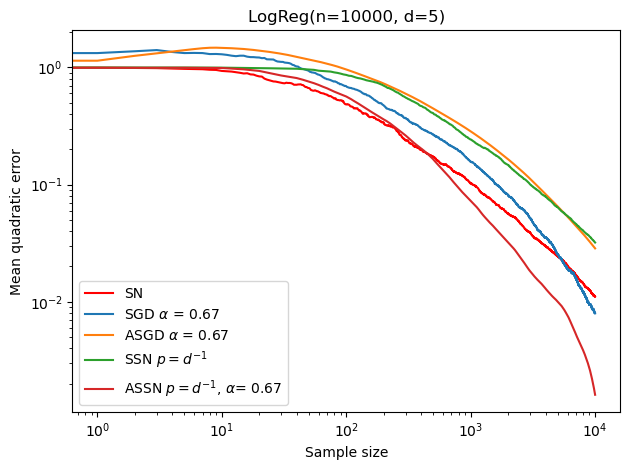

In [35]:
thetas_sn = run_online_sn(model, theta_0)
thetas_sgd = run_online_sgd(model, scheduler, theta_0)
thetas_asgd = run_online_sgd(model, scheduler, theta_0, averaged=True)
thetas_ssn = run_streaming_sn(model, theta_0)
thetas_assn = run_averaged_streaming_sn(model, scheduler, theta_0)

errors_sgd = np.square(thetas_sgd - theta_star.reshape(1, 1, -1)).sum(-1).mean(-1)
errors_asgd = np.square(thetas_asgd - theta_star.reshape(1, 1, -1)).sum(-1).mean(-1)
errors_sn = np.square(thetas_sn - theta_star.reshape(1, 1, -1)).sum(-1).mean(-1)
errors_ssn = np.square(thetas_ssn - theta_star.reshape(1, 1, -1)).sum(-1).mean(-1)
errors_assn = np.square(thetas_assn - theta_star.reshape(1, 1, -1)).sum(-1).mean(-1)

fig, ax = plt.subplots(layout="tight")

ax.loglog(errors_sn, label="SN", c="red")
ax.loglog(errors_sgd, label=rf"SGD $\alpha$ = {scheduler.alpha:.2f}")
ax.loglog(errors_asgd, label=rf"ASGD $\alpha$ = {scheduler.alpha:.2f}")
ax.loglog(np.arange(0, n + 1, d), errors_ssn, label=r"SSN $p=d^{-1}$")
ax.loglog(
    np.arange(0, n + 1, d),
    errors_assn,
    label=r"ASSN $p=d^{-1}$, $\alpha$" + f"= {scheduler.alpha:.2f}",
)

ax.set_xlabel("Sample size")
ax.set_ylabel("Mean quadratic error")
ax.set_title(f"{model}")
ax.legend()

plt.show()